In [4]:
train_emoticon_path = "./datasets/train/train_emoticon.csv"
valid_emoticon_path = "./datasets/valid/valid_emoticon.csv"
test_emoticon_path = "./datasets/test/test_emoticon.csv"



train_feature_path = "./datasets/train/train_feature.npz"
valid_feature_path = "./datasets/valid/valid_feature.npz"
test_feature_path = "./datasets/test/test_feature.npz"

train_text_seq_path = "./datasets/train/train_text_seq.csv"
valid_text_seq_path = "./datasets/valid/valid_text_seq.csv"
test_text_seq_path = "./datasets/test/test_text_seq.csv"

emoji2vec_path = "emoji2vec.bin"

In [1]:
# M1.1 Emoji2vec+500f+Direct

import pandas as pd
import numpy as np
import tensorflow as tf
import gensim
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Input
import matplotlib.pyplot as plt




# ------------------------ Define Paths at the Start ------------------------
train_emoticon_path = "./datasets/train/train_emoticon.csv"
valid_emoticon_path = "./datasets/valid/valid_emoticon.csv"
test_emoticon_path = "./datasets/test/test_emoticon.csv"



train_feature_path = "./datasets/train/train_feature.npz"
valid_feature_path = "./datasets/valid/valid_feature.npz"
test_feature_path = "./datasets/test/test_feature.npz"

train_text_seq_path = "./datasets/train/train_text_seq.csv"
valid_text_seq_path = "./datasets/valid/valid_text_seq.csv"
test_text_seq_path = "./datasets/test/test_text_seq.csv"

emoji2vec_path = "emoji2vec.bin"



# -------------------------- Dataset 1: Emoticon LSTM Model --------------------------

print("# -------------------------- Dataset 1--------------------------")
# Load the dataset
train_df = pd.read_csv(train_emoticon_path)
val_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)

# Split emoji strings into individual emojis
def split_emojis(emoji_string):
    return list(emoji_string)

train_df['input_emoticon'] = train_df['input_emoticon'].apply(split_emojis)
val_df['input_emoticon'] = val_df['input_emoticon'].apply(split_emojis)
test_df['input_emoticon'] = test_df['input_emoticon'].apply(split_emojis)

# Extract labels
y_train = train_df['label'].values
y_val = val_df['label'].values

# Tokenize emojis
tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['input_emoticon'])  # Fit tokenizer on training data
word_index = tokenizer.word_index

# Convert emojis to sequences of integers
X_train = tokenizer.texts_to_sequences(train_df['input_emoticon'])
X_val = tokenizer.texts_to_sequences(val_df['input_emoticon'])
X_test = tokenizer.texts_to_sequences(test_df['input_emoticon'])

# Padding sequences to ensure uniform input length (13 emojis per input)
X_train = pad_sequences(X_train, maxlen=13, padding='post')
X_val = pad_sequences(X_val, maxlen=13, padding='post')
X_test = pad_sequences(X_test, maxlen=13, padding='post')

vocab_size = len(word_index) + 1  # Adding 1 because of padding and OOV tokens

print(f"Train Shape: {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")
print(f"Test Shape: {X_test.shape}")


# LSTM model definition
def create_lstm_model():
    model = Sequential()
    model.add(Input(shape=(13,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=32))
    model.add(LSTM(12, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train with 100% of the data
model = create_lstm_model()
model.summary()
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=1)

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'Dataset 1 LSTM Validation Accuracy : {val_accuracy:.4f}')

# Make predictions on the test set and save to txt without any header
y_test_pred = model.predict(X_test)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
pd.DataFrame(y_test_pred_binary).to_csv('pred_emoticon.txt', index=False, header=False)


# ------------------------ Dataset 2: PCA then Classification Models ------------------------
print("# -------------------------- Dataset 2--------------------------")
# Load the dataset
data = np.load(train_feature_path, allow_pickle=True)
valid_data = np.load(valid_feature_path, allow_pickle=True)
test_data = np.load(test_feature_path, allow_pickle=True)

train_deep_X = data['features']
train_deep_Y = data['label']

valid_deep_X = valid_data['features']
valid_deep_Y = valid_data['label']

test_deep_X = test_data['features']

# Flatten the data for PCA
train_X_deep_flattened = train_deep_X.reshape(train_deep_X.shape[0], -1)
valid_X_deep_flattened = valid_deep_X.reshape(valid_deep_X.shape[0], -1)
test_X_deep_flattened = test_deep_X.reshape(test_deep_X.shape[0], -1)

# Perform PCA
n_components = 500
pca = PCA(n_components=n_components)
train_embeddings_pca = pca.fit_transform(train_X_deep_flattened)
validation_embeddings_pca = pca.transform(valid_X_deep_flattened)
test_embeddings_pca = pca.transform(test_X_deep_flattened)

print(f"Train Shape: {train_embeddings_pca.shape}")
print(f"Validation Shape: {validation_embeddings_pca.shape}")
print(f"Test Shape: {test_embeddings_pca.shape}")


# Train models and evaluate
models = {
#     "Ridge Regression": RidgeClassifier(),
#     "XG Boost": XGBClassifier(),
#     "SVM": SVC(C=0.01, degree=3, gamma='scale', kernel='linear'),
    "Logistic Regression": LogisticRegression(max_iter=500),
}


for model_name, model in models.items():
    model.fit(train_embeddings_pca, train_deep_Y)
    y_pred_valid = model.predict(validation_embeddings_pca)
    validation_accuracy = accuracy_score(valid_deep_Y, y_pred_valid)
    print(f"Dataset 2 {model_name} Validation Accuracy: {validation_accuracy:.4f}")
    y_test_pred = model.predict(test_embeddings_pca)
    pd.DataFrame(y_test_pred).to_csv('pred_deepfeat.txt', index=False, header=False)



# -------------------------- Dataset 3: GRU Model for Text Sequences --------------------------
print("# -------------------------- Dataset 3--------------------------")
# Load the dataset
train_df = pd.read_csv(train_text_seq_path)
validation_df = pd.read_csv(valid_text_seq_path)
test_df = pd.read_csv(test_text_seq_path)


X_train = np.array([[int(char) for char in seq] for seq in train_df['input_str']])
y_train = np.array(train_df['label'])

X_val = np.array([[int(char) for char in seq] for seq in validation_df['input_str']])
y_val = np.array(validation_df['label'])

X_test = np.array([[int(char) for char in seq] for seq in test_df['input_str']])

print(f"Train Shape: {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")
print(f"Test Shape: {X_test.shape}")

# Build GRU model
max_length = 50
vocab_size = 10
embedding_dim = 64
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='embedding_layer'))
model.add(GRU(units=28, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val),verbose=1)

# Evaluate on validation data
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
print(f"Dataset 3 GRU Validation Accuracy: {validation_accuracy:.4f}")

# Make predictions on the test set and save to txt
y_test_pred = model.predict(X_test)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
pd.DataFrame(y_test_pred_binary).to_csv('pred_textseq.txt', index=False, header=False)


#-----------------Task-2------------------------------------------------
print("# -------------------------- Combined Dataset --------------------------")
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import gensim
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, Input

# ---------- Dataset-2 Deep Features Processing----------
data = np.load(train_feature_path, allow_pickle=True)
valid_data = np.load(valid_feature_path, allow_pickle=True)
test_deep_data = np.load(test_feature_path, allow_pickle=True)

train_deep_X = data['features']
train_deep_Y = data['label']

valid_deep_X = valid_data['features']
valid_deep_Y = valid_data['label']

test_deep_X = test_deep_data['features']

train_X_deep_flattened = train_deep_X.reshape(train_deep_X.shape[0], -1)
valid_X_deep_flattened = valid_deep_X.reshape(valid_deep_X.shape[0], -1)
test_X_deep_flattened = test_deep_X.reshape(test_deep_X.shape[0], -1)

pca = PCA(n_components=500)
train_embeddings_pca = pca.fit_transform(train_X_deep_flattened)
validation_embeddings_pca = pca.transform(valid_X_deep_flattened)
test_embeddings_pca = pca.transform(test_X_deep_flattened)

# ---------- Dataset-1 Emoji Processing-----------
e2v = gensim.models.KeyedVectors.load_word2vec_format(emoji2vec_path, binary=True)

def get_emoji_embedding(emoji):
    try:
        return e2v[emoji]
    except KeyError:
        return np.zeros(300)

def get_aggregated_embedding(emoji_sequence):
    embeddings = [get_emoji_embedding(emoji) for emoji in emoji_sequence]
    return np.array(embeddings)

train_df = pd.read_csv(train_emoticon_path)
validation_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)

train_sequences = train_df['input_emoticon'].values
validation_sequences = validation_df['input_emoticon'].values
test_sequences = test_df['input_emoticon'].values

train_labels = train_df['label'].values
validation_labels = validation_df['label'].values

train_embeddings = np.array([get_aggregated_embedding(seq) for seq in train_sequences])
validation_embeddings = np.array([get_aggregated_embedding(seq) for seq in validation_sequences])
test_embeddings = np.array([get_aggregated_embedding(seq) for seq in test_sequences])

train_X_emoji_flattened = train_embeddings.reshape(train_embeddings.shape[0], -1)
valid_X_emoji_flattened = validation_embeddings.reshape(validation_embeddings.shape[0], -1)
test_X_emoji_flattened = test_embeddings.reshape(test_embeddings.shape[0], -1)

pca_emoji = PCA(n_components=1500)
train_embeddings_pca_emoji = pca_emoji.fit_transform(train_X_emoji_flattened)
validation_embeddings_pca_emoji = pca_emoji.transform(valid_X_emoji_flattened)
test_embeddings_pca_emoji = pca_emoji.transform(test_X_emoji_flattened)

#---------- Dataset-3: Text Sequence ----------
train_text_df = pd.read_csv(train_text_seq_path)
validation_text_df = pd.read_csv(valid_text_seq_path)
test_text_df = pd.read_csv(test_text_seq_path)

X_train_text = np.array([[int(char) for char in seq] for seq in train_text_df['input_str']])
y_train_text = np.array(train_text_df['label'])

X_val_text = np.array([[int(char) for char in seq] for seq in validation_text_df['input_str']])
y_val_text = np.array(validation_text_df['label'])

X_test_text = np.array([[int(char) for char in seq] for seq in test_text_df['input_str']])

# -----------Combine All Dataset Embeddings ----------
merged_data_train = np.concatenate((train_embeddings_pca, train_embeddings_pca_emoji, X_train_text), axis=1)
merged_data_valid = np.concatenate((validation_embeddings_pca, validation_embeddings_pca_emoji, X_val_text), axis=1)
merged_data_test = np.concatenate((test_embeddings_pca, test_embeddings_pca_emoji, X_test_text), axis=1)

print(f"Combined Train Shape: {merged_data_train.shape}")
print(f"Combined Validation Shape: {merged_data_valid.shape}")
print(f"Combined Test Shape: {merged_data_test.shape}")

# -----------Logistic Regression-------------
model = LogisticRegression(C= 1, penalty= 'l2', solver='saga',max_iter=2000)
model.fit(merged_data_train, train_deep_Y)

y_val_pred = model.predict(merged_data_valid)
y_test_pred = model.predict(merged_data_test)

val_accuracy = accuracy_score(valid_deep_Y, y_val_pred)
print(f"Combined Dataset Validation Accuracy: {val_accuracy}")

# pd.DataFrame(y_test_pred, columns=['Prediction']).to_csv('pred_combined.txt', index=False)
pd.DataFrame(y_test_pred).to_csv('pred_combined.txt', index=False, header=False)


2024-10-20 17:52:42.332318: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 17:52:42.378680: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 17:52:42.473123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 17:52:42.583411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 17:52:42.626700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 17:52:42.717819: I tensorflow/core/platform/cpu_feature_gu

# -------------------------- Dataset 1--------------------------
Train Shape: (7080, 13)
Validation Shape: (489, 13)
Test Shape: (2232, 13)


I0000 00:00:1729426966.616766   77330 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-20 17:52:46.621002: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 32)         │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12)             │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,969 (38.94 KB)

 Trainable params: 9,969 (38.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5701 - loss: 0.6632 - val_accuracy: 0.8998 - val_loss: 0.2633
Epoch 2/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8857 - loss: 0.2929 - val_accuracy: 0.9080 - val_loss: 0.2307
Epoch 3/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9041 - loss: 0.2493 - val_accuracy: 0.9223 - val_loss: 0.1955
Epoch 4/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9120 - loss: 0.2231 - val_accuracy: 0.9141 - val_loss: 0.2065
Epoch 5/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9241 - loss: 0.2085 - val_accuracy: 0.9264 - val_loss: 0.1736
Epoch 6/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9341 - loss: 0.1766 - val_accuracy: 0.9243 - val_loss: 0.1695
Epoch 7/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9345 - loss: 0.1606 - val_accuracy: 0.9243 - val_loss: 0.1679
Epoch 8/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9426 - loss: 0.1552 - val_accur

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 50, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 28)             │         7,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,497 (37.10 KB)

 Trainable params: 9,497 (37.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5014 - loss: 0.6933 - val_accuracy: 0.5685 - val_loss: 0.6867
Epoch 2/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5595 - loss: 0.6823 - val_accuracy: 0.6421 - val_loss: 0.6548
Epoch 3/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6151 - loss: 0.6560 - val_accuracy: 0.6708 - val_loss: 0.6286
Epoch 4/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6360 - loss: 0.6411 - val_accuracy: 0.6524 - val_loss: 0.6258
Epoch 5/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6489 - loss: 0.6315 - val_accuracy: 0.6605 - val_loss: 0.6185
Epoch 6/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6688 - loss: 0.6142 - val_accuracy: 0.6851 - val_loss: 0.6167
Epoch 7/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6626 - loss: 0.6108 - val_accuracy: 0.6851 - val_loss: 0.6022
Epoch 8/50
443/443 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.6782 - loss: 0.6002 - val_acc

In [2]:
# M1.2 emoji2vec+500f+Embedding

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Input



train_emoticon_path = "./datasets/train/train_emoticon.csv"
valid_emoticon_path = "./datasets/valid/valid_emoticon.csv"
test_emoticon_path = "./datasets/test/test_emoticon.csv"


train_feature_path = "./datasets/train/train_feature.npz"
valid_feature_path = "./datasets/valid/valid_feature.npz"
test_feature_path = "./datasets/test/test_feature.npz"

train_text_seq_path = "./datasets/train/train_text_seq.csv"
valid_text_seq_path = "./datasets/valid/valid_text_seq.csv"
test_text_seq_path = "./datasets/test/test_text_seq.csv"

emoji2vec_path = "emoji2vec.bin"




# -------------------------- Dataset 1: Emoticon LSTM Model --------------------------

# Load the dataset
train_df = pd.read_csv(train_emoticon_path)
val_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)


# Split emoji strings into individual emojis
def split_emojis(emoji_string):
    return list(emoji_string)

train_df['input_emoticon'] = train_df['input_emoticon'].apply(split_emojis)
val_df['input_emoticon'] = val_df['input_emoticon'].apply(split_emojis)
test_df['input_emoticon'] = test_df['input_emoticon'].apply(split_emojis)

# Extract labels
y_train = train_df['label'].values
y_val = val_df['label'].values

# Tokenize emojis
tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['input_emoticon'])  # Fit tokenizer on training data
word_index = tokenizer.word_index

# Convert emojis to sequences of integers
X_train = tokenizer.texts_to_sequences(train_df['input_emoticon'])
X_val = tokenizer.texts_to_sequences(val_df['input_emoticon'])
X_test = tokenizer.texts_to_sequences(test_df['input_emoticon'])

# Padding sequences to ensure uniform input length (13 emojis per input)
X_train = pad_sequences(X_train, maxlen=13, padding='post')
X_val = pad_sequences(X_val, maxlen=13, padding='post')
X_test = pad_sequences(X_test, maxlen=13, padding='post')

vocab_size = len(word_index) + 1  # Adding 1 because of padding and OOV tokens

# GRU model definition
def create_gru_model():
    model = Sequential()
    model.add(Input(shape=(13,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=32,name='embedding_layer_emoji'))

    model.add(GRU(12, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train with 100% of the data
model = create_gru_model()
model.summary()
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'GRU Validation Accuracy on Dataset 1: {val_accuracy:.4f}')

# Make predictions on the test set and save to CSV
y_test_pred = model.predict(X_test)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
pd.DataFrame(y_test_pred_binary, columns=['Prediction']).to_csv('pred_emoticon.txt', index=False)



# ------------------------ Dataset 2: PCA and Classification Models ------------------------

# Load the dataset
data = np.load(train_feature_path, allow_pickle=False)
train_deep_X = data['features']
train_deep_Y = data['label']

# Load validation set
valid_data = np.load(valid_feature_path, allow_pickle=False)
valid_deep_X = valid_data['features']
valid_deep_Y = valid_data['label']

# Load test set
test_data = np.load(test_feature_path, allow_pickle=False)
test_deep_X = test_data['features']

# Flatten the data for PCA
train_X_deep_flattened = train_deep_X.reshape(train_deep_X.shape[0], -1)
valid_X_deep_flattened = valid_deep_X.reshape(valid_deep_X.shape[0], -1)
test_X_deep_flattened = test_deep_X.reshape(test_deep_X.shape[0], -1)

# Perform PCA
n_components = 500
pca = PCA(n_components=n_components)
train_embeddings_pca = pca.fit_transform(train_X_deep_flattened)
validation_embeddings_pca = pca.transform(valid_X_deep_flattened)
test_embeddings_pca = pca.transform(test_X_deep_flattened)

# Train models and evaluate
models = {
#     "Ridge Regression": RidgeClassifier(),
#     "XG Boost": XGBClassifier(),
#     "SVM": SVC(C=0.01, degree=3, gamma='scale', kernel='linear'),
    "Logistic Regression": LogisticRegression(max_iter=500),
}

# Train with 100% of the data
for model_name, model in models.items():
    model.fit(train_embeddings_pca, train_deep_Y)
    y_pred_valid = model.predict(validation_embeddings_pca)
    validation_accuracy = accuracy_score(valid_deep_Y, y_pred_valid)
    print(f"{model_name} Validation Accuracy: {validation_accuracy:.4f}")
    y_test_pred = model.predict(test_embeddings_pca)
    pd.DataFrame(y_test_pred, columns=['Prediction']).to_csv('pred_deepfeat.txt', index=False)


# -------------------------- Dataset 3: GRU Model for Text Sequences --------------------------

# Load the dataset
train_df = pd.read_csv(train_text_seq_path)
validation_df = pd.read_csv(valid_text_seq_path)
test_df = pd.read_csv(test_text_seq_path)

X_train = np.array([[int(char) for char in seq] for seq in train_df['input_str']])
y_train = np.array(train_df['label'])

X_val = np.array([[int(char) for char in seq] for seq in validation_df['input_str']])
y_val = np.array(validation_df['label'])

X_test = np.array([[int(char) for char in seq] for seq in test_df['input_str']])

# Build GRU model
max_length = 50
vocab_size = 10
embedding_dim = 64
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='embedding_layer'))
model.add(GRU(units=28, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# Train with 100% of the data
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val),verbose=0)

# Evaluate on validation data
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
print(f"GRU Validation Accuracy: {validation_accuracy:.4f}")

# Make predictions on the test set and save to CSV
y_test_pred = model.predict(X_test)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
pd.DataFrame(y_test_pred_binary, columns=['Prediction']).to_csv('pred_textseq.txt', index=False)


# Extract the weights from the embedding layer after training
embedding_layer = model.get_layer('embedding_layer')
embedding_weights = embedding_layer.get_weights()[0]  # The embedding matrix

def apply_embeddings(input_data, embedding_weights):
    # Convert each sequence of integers into a sequence of embedding vectors
    embedded_data = np.array([[embedding_weights[char] for char in seq] for seq in input_data])
    return embedded_data

# Apply the embedding transformation to the training, validation, and test data
X_train_embedded = apply_embeddings(X_train, embedding_weights)
X_val_embedded = apply_embeddings(X_val, embedding_weights)
X_test_embedded = apply_embeddings(X_test, embedding_weights)


X_train_embedded_flattened = X_train_embedded.reshape(X_train_embedded.shape[0], -1)
X_val_embedded_flattened = X_val_embedded.reshape(X_val_embedded.shape[0], -1)
X_test_embedded_flattened = X_test_embedded.reshape(X_test_embedded.shape[0], -1)


#-----------------Task-2------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import gensim
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, Input





# ---------- Dataset-2 Deep Features Processing----------
data = np.load(train_feature_path, allow_pickle=False)
train_deep_X = data['features']
train_deep_Y = data['label']
valid_data = np.load(valid_feature_path, allow_pickle=False)
valid_deep_X = valid_data['features']
valid_deep_Y = valid_data['label']

test_deep_data = np.load(test_feature_path, allow_pickle=False)
test_deep_X = test_deep_data['features']

train_X_deep_flattened = train_deep_X.reshape(train_deep_X.shape[0], -1)
valid_X_deep_flattened = valid_deep_X.reshape(valid_deep_X.shape[0], -1)
test_X_deep_flattened = test_deep_X.reshape(test_deep_X.shape[0], -1)

pca = PCA(n_components=500)
train_embeddings_pca = pca.fit_transform(train_X_deep_flattened)
validation_embeddings_pca = pca.transform(valid_X_deep_flattened)
test_embeddings_pca = pca.transform(test_X_deep_flattened)

# ---------- Dataset-1 Emoji Processing-----------

e2v = gensim.models.KeyedVectors.load_word2vec_format(emoji2vec_path, binary=True)

def get_emoji_embedding(emoji):
    try:
        return e2v[emoji]
    except KeyError:
        return np.zeros(300)

def get_aggregated_embedding(emoji_sequence):
    embeddings = [get_emoji_embedding(emoji) for emoji in emoji_sequence]
    return np.array(embeddings)


train_df = pd.read_csv(train_emoticon_path)
validation_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)

train_sequences = train_df['input_emoticon'].values
validation_sequences = validation_df['input_emoticon'].values
test_sequences = test_df['input_emoticon'].values

train_labels = train_df['label'].values
validation_labels = validation_df['label'].values

train_embeddings = np.array([get_aggregated_embedding(seq) for seq in train_sequences])
validation_embeddings = np.array([get_aggregated_embedding(seq) for seq in validation_sequences])
test_embeddings = np.array([get_aggregated_embedding(seq) for seq in test_sequences])

train_X_emoji_flattened = train_embeddings.reshape(train_embeddings.shape[0], -1)
valid_X_emoji_flattened = validation_embeddings.reshape(validation_embeddings.shape[0], -1)
test_X_emoji_flattened = test_embeddings.reshape(test_embeddings.shape[0], -1)

pca_emoji = PCA(n_components=1500)
train_embeddings_pca_emoji = pca_emoji.fit_transform(train_X_emoji_flattened)
validation_embeddings_pca_emoji = pca_emoji.transform(valid_X_emoji_flattened)
test_embeddings_pca_emoji = pca_emoji.transform(test_X_emoji_flattened)


merged_data_train = np.concatenate((train_embeddings_pca, train_embeddings_pca_emoji), axis=1)
merged_data_valid = np.concatenate((validation_embeddings_pca, validation_embeddings_pca_emoji), axis=1)
merged_data_test = np.concatenate((test_embeddings_pca, test_embeddings_pca_emoji), axis=1)

print(merged_data_train.shape)
print(merged_data_valid.shape)
print(merged_data_test.shape)


#---------- Dataset-3: Text Sequence Processing ----------
n_components = 450
pca = PCA(n_components=n_components)
train_embeddings_pca = pca.fit_transform(X_train_embedded_flattened)
validation_embeddings_pca = pca.transform(X_val_embedded_flattened)
test_embeddings_pca = pca.transform(X_test_embedded_flattened)

explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
print(f"Total retained variance by {n_components} components: {explained_variance_ratio * 100:.2f}%")

print(f"Train Embeddings Shape after PCA: {train_embeddings_pca.shape}")
print(f"Validation Embeddings Shape after PCA: {validation_embeddings_pca.shape}")
print(f"Test Embeddings Shape after PCA: {test_embeddings_pca.shape}")

merged_data_train = np.concatenate((merged_data_train, train_embeddings_pca), axis=1)
merged_data_valid = np.concatenate((merged_data_valid, validation_embeddings_pca), axis=1)
merged_data_test = np.concatenate((merged_data_test, test_embeddings_pca), axis=1)


# -----------Combine All Dataset Embeddings ----------

print(f"Combined Train Shape: {merged_data_train.shape}")
print(f"Combined Validation Shape: {merged_data_valid.shape}")
print(f"Combined Test Shape: {merged_data_test.shape}")

# -----------Logistic Regression-------------
model = LogisticRegression(C= 1, penalty= 'l2', solver='saga',max_iter=2000)
model.fit(merged_data_train, train_deep_Y)

y_val_pred = model.predict(merged_data_valid)
y_test_pred = model.predict(merged_data_test)

val_accuracy = accuracy_score(valid_deep_Y, y_val_pred)
print(f"Validation Accuracy on combined: {val_accuracy}")

pd.DataFrame(y_test_pred, columns=['Prediction']).to_csv('pred_combined.txt', index=False)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer_emoji           │ (None, 13, 32)         │         6,912 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 12)             │         1,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,465 (36.97 KB)

 Trainable params: 9,465 (36.97 KB)

 Non-trainable params: 0 (0.00 B)

GRU Validation Accuracy on Dataset 1: 0.9652
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Logistic Regression Validation Accuracy: 0.9836


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 50, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 28)             │         7,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,497 (37.10 KB)

 Trainable params: 9,497 (37.10 KB)

 Non-trainable params: 0 (0.00 B)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8783 - loss: 0.4499
GRU Validation Accuracy: 0.8732
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
(7080, 2000)
(489, 2000)
(2232, 2000)
Total retained variance by 450 components: 100.00%
Train Embeddings Shape after PCA: (7080, 450)
Validation Embeddings Shape after PCA: (489, 450)
Test Embeddings Shape after PCA: (2232, 450)
Combined Train Shape: (7080, 2450)
Combined Validation Shape: (489, 2450)
Combined Test Shape: (2232, 2450)
Validation Accuracy on combined: 0.9693251533742331


In [4]:
models = {
    "Ridge Regression": RidgeClassifier(),
    "XG Boost": XGBClassifier(),
    "SVM": SVC(C=0.01, degree=3, gamma='scale', kernel='linear'),
    "Logistic Regression": LogisticRegression(C=1,max_iter=1000),
}


percentages = np.linspace(0.2, 1.0, 5)
results = []
for percent in percentages:
    n_samples = int(len(merged_data_train) * percent)
    print(f"\nTraining with {percent*100:.1f}% of the data ({n_samples} samples)")

    # Select a subset of training data based on the percentage
    X_subset = merged_data_train[:n_samples]
    y_subset = train_deep_Y[:n_samples]

    # Train and evaluate models
    for model_name, model in models.items():
        model.fit(X_subset, y_subset)

        y_pred_valid = model.predict(merged_data_valid)
        validation_accuracy = accuracy_score(valid_deep_Y, y_pred_valid)
        print(f"Validation accuracy for {model_name}: {validation_accuracy}")
        results.append([percent * 100, model_name, validation_accuracy])


df = pd.DataFrame(results, columns=['percent', 'model_name', 'validation_accuracy'])

plt.figure(figsize=(10, 6))

for model_name in df['model_name'].unique():
    model_df = df[df['model_name'] == model_name]
    plt.plot(model_df['percent'], model_df['validation_accuracy'], marker='o', label=model_name)

plt.title('Validation Accuracy vs. Percentage of Data Used (With Hyperparameter Tuning)')
plt.xlabel('Percentage of Data Used (%)')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model Name')
plt.show()


Training with 20.0% of the data (1416 samples)
Validation accuracy for Ridge Regression: 0.8159509202453987
Validation accuracy for XG Boost: 0.9366053169734151
Validation accuracy for SVM: 0.9038854805725971
Validation accuracy for Logistic Regression: 0.934560327198364

Training with 40.0% of the data (2832 samples)
Validation accuracy for Ridge Regression: 0.8466257668711656
Validation accuracy for XG Boost: 0.950920245398773
Validation accuracy for SVM: 0.9386503067484663
Validation accuracy for Logistic Regression: 0.9570552147239264

Training with 60.0% of the data (4248 samples)
Validation accuracy for Ridge Regression: 0.8773006134969326
Validation accuracy for XG Boost: 0.9693251533742331
Validation accuracy for SVM: 0.9325153374233128
Validation accuracy for Logistic Regression: 0.9693251533742331

Training with 80.0% of the data (5664 samples)
Validation accuracy for Ridge Regression: 0.8895705521472392
Validation accuracy for XG Boost: 0.9775051124744376
Validation accurac

NameError: name 'plt' is not defined

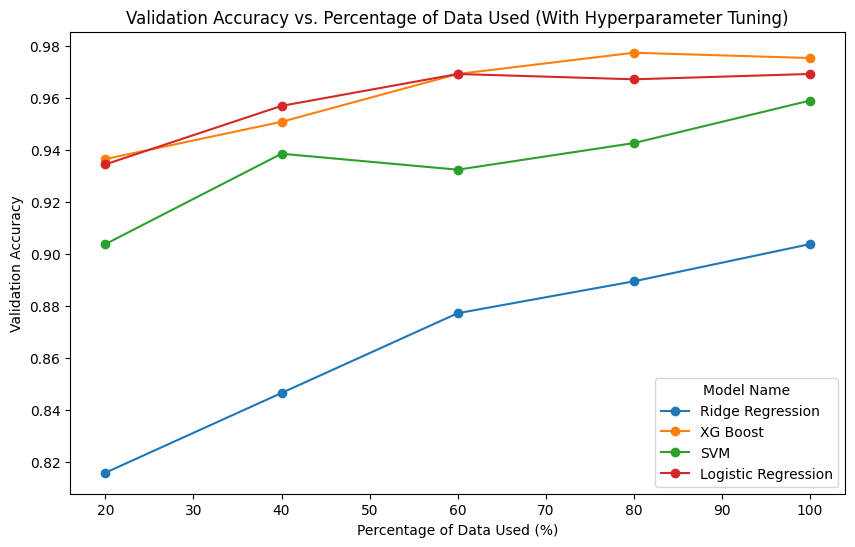

In [6]:

plt.figure(figsize=(10, 6))

for model_name in df['model_name'].unique():
    model_df = df[df['model_name'] == model_name]
    plt.plot(model_df['percent'], model_df['validation_accuracy'], marker='o', label=model_name)

plt.title('Validation Accuracy vs. Percentage of Data Used (With Hyperparameter Tuning)')
plt.xlabel('Percentage of Data Used (%)')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model Name')
plt.show()

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score
import itertools

# List of all the prediction files
files = [
    "pred_combined.txt",
    "pred_emoticon.txt",
    "pred_deepfeat.txt",
    "pred_textseq.txt",
]

# Load all predictions into a dictionary
predictions = {}
for file in files:
    # Load each prediction file assuming 'Prediction' is the column name
    predictions[file] = pd.read_csv(file).values

# Get all unique pairs of files
pairs = list(itertools.combinations(files, 2))

# Loop over each pair and calculate accuracy score
for file1, file2 in pairs:
    # Extract the predictions for the two files
    y_pred_1 = predictions[file1]
    y_pred_2 = predictions[file2]

    # Check if the lengths of the predictions match
    if len(y_pred_1) != len(y_pred_2):
        print(f"Error: {file1} and {file2} have different lengths!")
    else:
        # Calculate and print the accuracy score between the two files
        accuracy = accuracy_score(y_pred_1, y_pred_2)
        print(f"Accuracy between {file1.split('/')[-1]} and {file2.split('/')[-1]}: {accuracy:.4f}")


Accuracy between pred_combined.txt and pred_emoticon.txt: 0.6477
Accuracy between pred_combined.txt and pred_deepfeat.txt: 0.9758
Accuracy between pred_combined.txt and pred_textseq.txt: 0.6885
Accuracy between pred_emoticon.txt and pred_deepfeat.txt: 0.6378
Accuracy between pred_emoticon.txt and pred_textseq.txt: 0.7593
Accuracy between pred_deepfeat.txt and pred_textseq.txt: 0.6867


In [ ]:
# M2 Onehot +500f+ Direct

# Emoji One hot

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout ,Bidirectional
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


# ---------- Dataset-2 Deep Features Processing----------
data = np.load(train_feature_path, allow_pickle=True)
train_deep_X = data['features']
train_deep_Y = data['label']
valid_data = np.load(valid_feature_path, allow_pickle=True)
valid_deep_X = valid_data['features']
valid_deep_Y = valid_data['label']

test_deep_data = np.load(test_feature_path, allow_pickle=True)
test_deep_X = test_deep_data['features']

train_X_deep_flattened = train_deep_X.reshape(train_deep_X.shape[0], -1)
valid_X_deep_flattened = valid_deep_X.reshape(valid_deep_X.shape[0], -1)
test_X_deep_flattened = test_deep_X.reshape(test_deep_X.shape[0], -1)

pca = PCA(n_components=500)
train_embeddings_pca = pca.fit_transform(train_X_deep_flattened)
validation_embeddings_pca = pca.transform(valid_X_deep_flattened)
test_embeddings_pca = pca.transform(test_X_deep_flattened)




# ---------- Dataset-1 Emoji OneHot----------
# Function to split emoji strings into individual emojis
def split_emojis(emoji_string):
    return list(emoji_string)

# Load the training and validation datasets

train_df = pd.read_csv(train_emoticon_path)
val_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)

# Split the emojis in the 'input_emoticon' column
train_df['input_emoticon'] = train_df['input_emoticon'].apply(split_emojis)
val_df['input_emoticon'] = val_df['input_emoticon'].apply(split_emojis)
test_df['input_emoticon'] = test_df['input_emoticon'].apply(split_emojis)

# Find all unique emojis in both training and validation datasets
unique_emojis = set()

for row in train_df['input_emoticon']:
    unique_emojis.update(row)

for row in val_df['input_emoticon']:
    unique_emojis.update(row)


unique_emojis = sorted(list(unique_emojis))  # Sort for consistency
print(len(unique_emojis))

# Create a dictionary to map each unique emoji to an index for one-hot encoding
emoji_to_index = {emoji: idx for idx, emoji in enumerate(unique_emojis)}

# Step 3: Function to convert a row of 13 emojis into an unflattened one-hot matrix (13xN)
def one_hot_encode_row(emoji_row, unique_emojis, emoji_to_index):
    # Create a matrix for 13 emojis (each row corresponding to an emoji, columns to unique emojis)
    one_hot_matrix = np.zeros((13, len(unique_emojis)))

    # Fill the matrix with one-hot encoding
    for i, emoji in enumerate(emoji_row):
        # Get the index of the emoji, or return None if it's not in emoji_to_index
        emoji_idx = emoji_to_index.get(emoji, None)

        # If the emoji is found in the dictionary, set the corresponding one-hot vector
        if emoji_idx is not None:
            one_hot_matrix[i, emoji_idx] = 1
        # If the emoji is not found, the row will remain a zero vector

    return one_hot_matrix

# Step 4: Apply one-hot encoding to all rows in training and validation data (as 13xN matrices)
X_train = np.array([one_hot_encode_row(row, unique_emojis, emoji_to_index) for row in train_df['input_emoticon']])
X_val = np.array([one_hot_encode_row(row, unique_emojis, emoji_to_index) for row in val_df['input_emoticon']])

X_test=np.array([one_hot_encode_row(row, unique_emojis, emoji_to_index) for row in test_df['input_emoticon']])

# Extract labels
y_train = train_df['label'].values
y_val = val_df['label'].values


print(f"Train Embeddings: {X_train.shape}")
print(f"Validation Embeddings: {X_val.shape}")
print(f"Test Embeddings: {X_test.shape}")

train_X_emoji_flattened = X_train.reshape(X_train.shape[0], -1)
valid_X_emoji_flattened = X_val.reshape(X_val.shape[0], -1)
test_X_emoji_flattened = X_test.reshape(X_test.shape[0], -1)



merged_data_train = np.concatenate((train_embeddings_pca, train_X_emoji_flattened), axis=1)
merged_data_valid = np.concatenate((validation_embeddings_pca, valid_X_emoji_flattened), axis=1)
merged_data_test = np.concatenate((test_embeddings_pca, test_X_emoji_flattened), axis=1)

print(merged_data_train.shape)
print(merged_data_valid.shape)
print(merged_data_test.shape)


#---------- Dataset-3: Text Sequence Processing ----------
train_text_df = pd.read_csv(train_text_seq_path)
validation_text_df = pd.read_csv(valid_text_seq_path)
test_text_df = pd.read_csv(test_text_seq_path)

X_train_text = np.array([[int(char) for char in seq] for seq in train_text_df['input_str']])
y_train_text = np.array(train_text_df['label'])

X_val_text = np.array([[int(char) for char in seq] for seq in validation_text_df['input_str']])
y_val_text = np.array(validation_text_df['label'])

X_test_text = np.array([[int(char) for char in seq] for seq in test_text_df['input_str']])

merged_data_train = np.concatenate((merged_data_train, X_train_text), axis=1)
merged_data_valid = np.concatenate((merged_data_valid, X_val_text), axis=1)
merged_data_test = np.concatenate((merged_data_test, X_test_text), axis=1)


# -----------Combine All Dataset Embeddings ----------

print(f"Combined Train Shape: {merged_data_train.shape}")
print(f"Combined Validation Shape: {merged_data_valid.shape}")
print(f"Combined Test Shape: {merged_data_test.shape}")

# -----------Logistic Regression-------------

models = {
    "Ridge Regression": RidgeClassifier(),
    "XG Boost": XGBClassifier(),
    "SVM": SVC(C=0.01, degree=3, gamma='scale', kernel='linear'),
    "Logistic Regression": LogisticRegression(C= 1, penalty= 'l2', solver='saga',max_iter=2000),
}

for model_name, model in models.items():
    model.fit(merged_data_train, train_deep_Y)

    y_pred_valid = model.predict(merged_data_valid)
    validation_accuracy = accuracy_score(valid_deep_Y, y_pred_valid)
    print(f"Validation accuracy for {model_name}: {validation_accuracy}")

# y_test_pred = model.predict(merged_data_test)
# pd.DataFrame(y_test_pred, columns=['Prediction']).to_csv('pred_combined.txt', index=False)


# pd.DataFrame(y_test_pred, columns=['Prediction']).to_csv('pred_combined.txt', index=False)


In [ ]:
# M3 Embedding+500f+Embedding

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Input
from sklearn.model_selection import train_test_split
import gensim
import tensorflow as tf




train_emoticon_path = "./datasets/train/train_emoticon.csv"
valid_emoticon_path = "./datasets/valid/valid_emoticon.csv"
test_emoticon_path = "./datasets/test/test_emoticon.csv"


train_feature_path = "./datasets/train/train_feature.npz"
valid_feature_path = "./datasets/valid/valid_feature.npz"
test_feature_path = "./datasets/test/test_feature.npz"

train_text_seq_path = "./datasets/train/train_text_seq.csv"
valid_text_seq_path = "./datasets/valid/valid_text_seq.csv"
test_text_seq_path = "./datasets/test/test_text_seq.csv"

emoji2vec_path = "emoji2vec.bin"



# -------------------------- Dataset 1: Emoticon LSTM Model --------------------------

# Load the dataset
train_df = pd.read_csv(train_emoticon_path)
val_df = pd.read_csv(valid_emoticon_path)
test_df = pd.read_csv(test_emoticon_path)


# Split emoji strings into individual emojis
def split_emojis(emoji_string):
    return list(emoji_string)

train_df['input_emoticon'] = train_df['input_emoticon'].apply(split_emojis)
val_df['input_emoticon'] = val_df['input_emoticon'].apply(split_emojis)
test_df['input_emoticon'] = test_df['input_emoticon'].apply(split_emojis)

# Extract labels
y_train = train_df['label'].values
y_val = val_df['label'].values

# Tokenize emojis
tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['input_emoticon'])  # Fit tokenizer on training data
word_index = tokenizer.word_index

# Convert emojis to sequences of integers
X_train = tokenizer.texts_to_sequences(train_df['input_emoticon'])
X_val = tokenizer.texts_to_sequences(val_df['input_emoticon'])
X_test = tokenizer.texts_to_sequences(test_df['input_emoticon'])

# Padding sequences to ensure uniform input length (13 emojis per input)
X_train = pad_sequences(X_train, maxlen=13, padding='post')
X_val = pad_sequences(X_val, maxlen=13, padding='post')
X_test = pad_sequences(X_test, maxlen=13, padding='post')

vocab_size = len(word_index) + 1  # Adding 1 because of padding and OOV tokens

# GRU model definition
def create_gru_model():
    model = Sequential()
    model.add(Input(shape=(13,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=32,name='embedding_layer_emoji'))

    model.add(GRU(12, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train with 100% of the data
model = create_gru_model()
model.summary()
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val), verbose=0)

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'GRU Validation Accuracy on Dataset 1: {val_accuracy:.4f}')

# Make predictions on the test set and save to CSV
y_test_pred = model.predict(X_test)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
pd.DataFrame(y_test_pred_binary, columns=['Prediction']).to_csv('pred_emoticon.txt', index=False)


# Extract the weights from the embedding layer after training
embedding_layer = model.get_layer('embedding_layer_emoji')
embedding_weights = embedding_layer.get_weights()[0]  # The embedding matrix

# Print the shape of the embedding matrix
print(f"Embedding weights shape: {embedding_weights.shape}")  # (vocab_size, embedding_dim)

# Function to apply embeddings directly to the input data
def apply_embeddings(input_data, embedding_weights):
    # Convert each sequence of integers into a sequence of embedding vectors
    embedded_data = np.array([[embedding_weights[char] for char in seq] for seq in input_data])
    return embedded_data

# Apply the embedding transformation to the training, validation, and test data
X_train_embedded = apply_embeddings(X_train, embedding_weights)
X_val_embedded = apply_embeddings(X_val, embedding_weights)
X_test_embedded=apply_embeddings(X_test, embedding_weights)


train_X_emoji_flattened = X_train_embedded.reshape(X_train_embedded.shape[0], -1)
valid_X_emoji_flattened = X_val_embedded.reshape(X_val_embedded.shape[0], -1)
test_X_emoji_flattened = X_test_embedded.reshape(X_test_embedded.shape[0], -1)




# -------------------------- Dataset 3: GRU Model for Text Sequences --------------------------

# Load the dataset
train_df = pd.read_csv(train_text_seq_path)
validation_df = pd.read_csv(valid_text_seq_path)
test_df = pd.read_csv(test_text_seq_path)

X_train = np.array([[int(char) for char in seq] for seq in train_df['input_str']])
y_train = np.array(train_df['label'])

X_val = np.array([[int(char) for char in seq] for seq in validation_df['input_str']])
y_val = np.array(validation_df['label'])

X_test = np.array([[int(char) for char in seq] for seq in test_df['input_str']])

# Build GRU model
max_length = 50
vocab_size = 10
embedding_dim = 64
model = Sequential()
model.add(Input(shape=(max_length,)))
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='embedding_layer'))
model.add(GRU(units=28, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# Train with 100% of the data
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val),verbose=0)

# Evaluate on validation data
validation_loss, validation_accuracy = model.evaluate(X_val, y_val)
print(f"GRU Validation Accuracy: {validation_accuracy:.4f}")

# Make predictions on the test set and save to CSV
y_test_pred = model.predict(X_test)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
pd.DataFrame(y_test_pred_binary, columns=['Prediction']).to_csv('pred_textseq.txt', index=False)


# Extract the weights from the embedding layer after training
embedding_layer = model.get_layer('embedding_layer')
embedding_weights = embedding_layer.get_weights()[0]  # The embedding matrix

def apply_embeddings(input_data, embedding_weights):
    # Convert each sequence of integers into a sequence of embedding vectors
    embedded_data = np.array([[embedding_weights[char] for char in seq] for seq in input_data])
    return embedded_data

# Apply the embedding transformation to the training, validation, and test data
X_train_embedded = apply_embeddings(X_train, embedding_weights)
X_val_embedded = apply_embeddings(X_val, embedding_weights)
X_test_embedded = apply_embeddings(X_test, embedding_weights)


X_train_embedded_flattened = X_train_embedded.reshape(X_train_embedded.shape[0], -1)
X_val_embedded_flattened = X_val_embedded.reshape(X_val_embedded.shape[0], -1)
X_test_embedded_flattened = X_test_embedded.reshape(X_test_embedded.shape[0], -1)


#-----------------Task-2------------------------------------------------





# ---------- Dataset-2 Deep Features Processing----------
data = np.load(train_feature_path, allow_pickle=True)
train_deep_X = data['features']
train_deep_Y = data['label']
valid_data = np.load(valid_feature_path, allow_pickle=True)
valid_deep_X = valid_data['features']
valid_deep_Y = valid_data['label']

test_deep_data = np.load(test_feature_path, allow_pickle=True)
test_deep_X = test_deep_data['features']

train_X_deep_flattened = train_deep_X.reshape(train_deep_X.shape[0], -1)
valid_X_deep_flattened = valid_deep_X.reshape(valid_deep_X.shape[0], -1)
test_X_deep_flattened = test_deep_X.reshape(test_deep_X.shape[0], -1)

pca = PCA(n_components=500)
train_embeddings_pca = pca.fit_transform(train_X_deep_flattened)
validation_embeddings_pca = pca.transform(valid_X_deep_flattened)
test_embeddings_pca = pca.transform(test_X_deep_flattened)

# ---------- Dataset-1 Emoji Processing-----------

merged_data_train = np.concatenate((train_embeddings_pca, train_X_emoji_flattened), axis=1)
merged_data_valid = np.concatenate((validation_embeddings_pca, valid_X_emoji_flattened), axis=1)
merged_data_test = np.concatenate((test_embeddings_pca, test_X_emoji_flattened), axis=1)

print(merged_data_train.shape)
print(merged_data_valid.shape)
print(merged_data_test.shape)


#---------- Dataset-3: Text Sequence Processing ----------
n_components = 450
pca = PCA(n_components=n_components)
train_embeddings_pca = pca.fit_transform(X_train_embedded_flattened)
validation_embeddings_pca = pca.transform(X_val_embedded_flattened)
test_embeddings_pca = pca.transform(X_test_embedded_flattened)

explained_variance_ratio = np.sum(pca.explained_variance_ratio_)
print(f"Total retained variance by {n_components} components: {explained_variance_ratio * 100:.2f}%")

print(f"Train Embeddings Shape after PCA: {train_embeddings_pca.shape}")
print(f"Validation Embeddings Shape after PCA: {validation_embeddings_pca.shape}")
print(f"Test Embeddings Shape after PCA: {test_embeddings_pca.shape}")

merged_data_train = np.concatenate((merged_data_train, train_embeddings_pca), axis=1)
merged_data_valid = np.concatenate((merged_data_valid, validation_embeddings_pca), axis=1)
merged_data_test = np.concatenate((merged_data_test, test_embeddings_pca), axis=1)


# -----------Combine All Dataset Embeddings ----------

print(f"Combined Train Shape: {merged_data_train.shape}")
print(f"Combined Validation Shape: {merged_data_valid.shape}")
print(f"Combined Test Shape: {merged_data_test.shape}")

# -----------Logistic Regression-------------
model = LogisticRegression(C= 1, penalty= 'l2', solver='saga',max_iter=2000)
model.fit(merged_data_train, train_deep_Y)

y_val_pred = model.predict(merged_data_valid)
y_test_pred = model.predict(merged_data_test)

val_accuracy = accuracy_score(valid_deep_Y, y_val_pred)
print(f"Validation Accuracy on combined: {val_accuracy}")

pd.DataFrame(y_test_pred, columns=['Prediction']).to_csv('pred_combined.txt', index=False)
